In [1]:
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from more_itertools import chunked
from functools import reduce
from typing import List
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib
import os


El objetivo de este Notebook es preparar los datos para modelar con redes neuronales

In [2]:
# Reducir memoria automáticamente
def optimizar_memoria(df):
    for col in df.select_dtypes(include=['int64', 'int32']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64', 'float32']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [3]:
# Abrir el archivo parquet y cargarlo en un DataFrame data/l_vm_completa_train_pendientes.parquet
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')
df_pendientes = pd.read_parquet('./data/l_vm_completa_train_pendientes.parquet', engine='fastparquet')

In [4]:
# Concatenar los DataFrames df_full y df_pendientes por PRODUCT_ID,CUSTOMER_ID y PERIODO
df_full = pd.merge(
    df_full,
    df_pendientes,
    on=['PRODUCT_ID', 'CUSTOMER_ID', 'PERIODO'],
    how='inner'  # solo filas que existen en ambos DataFrames
)

In [5]:
# Buscar en df_full los product_id, customer_id que solo tienen ceros en TN
def buscar_productos_solo_ceros(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(['PRODUCT_ID', 'CUSTOMER_ID'])['TN'].sum().reset_index()
    productos_solo_ceros = grouped[grouped['TN'] == 0]
    return productos_solo_ceros

productos_solo_ceros = buscar_productos_solo_ceros(df_full)
print(f"🔍 Combinaciones PRODUCT_ID + CUSTOMER_ID con TN = 0 en todos sus registros: {len(productos_solo_ceros)}")

# Eliminar del df_full los product_id, customer_id que solo tienen ceros en TN
def eliminar_productos_solo_ceros(df: pd.DataFrame, productos_solo_ceros: pd.DataFrame) -> pd.DataFrame:
    productos_set = set(zip(productos_solo_ceros['PRODUCT_ID'], productos_solo_ceros['CUSTOMER_ID']))
    mask = df.set_index(['PRODUCT_ID', 'CUSTOMER_ID']).index.isin(productos_set)
    
    cantidad_eliminada = mask.sum()
    print(f"🗑️ Filas eliminadas de df_full: {cantidad_eliminada:,}")
    
    df_filtrado = df[~mask]
    return df_filtrado

df_full = eliminar_productos_solo_ceros(df_full, productos_solo_ceros)


🔍 Combinaciones PRODUCT_ID + CUSTOMER_ID con TN = 0 en todos sus registros: 327068
🗑️ Filas eliminadas de df_full: 6,594,430


In [6]:
# Eliminar de df_full las filas donde la columna A_PREDECIR sea 'N'
df_full = df_full[df_full['A_PREDECIR'] != 'N']
df_full = df_full.drop(columns=['A_PREDECIR'])

In [7]:
# Calcular para cada combinación:
grouped = df_full.groupby(['PRODUCT_ID', 'CUSTOMER_ID'])
stats = grouped['TN'].agg(
    count='count',
    nonzero_count=lambda x: (x != 0).sum(),
    nonzero_pct=lambda x: (x != 0).mean(),
    abs_sum=lambda x: x.abs().sum(),
    mean='mean'
).reset_index()

# Definir criterio de "mover la aguja" (ajustá los thresholds)
min_n_nonzero = 12   # mínimo 12 movimientos
min_pct_nonzero = 0.30  # al menos 30% de los registros son no cero
min_abs_sum = 5    # suma absoluta de los movimientos

mueven_aguja = stats[
    (stats['nonzero_count'] >= min_n_nonzero) &
    (stats['nonzero_pct'] >= min_pct_nonzero) &
    (stats['abs_sum'] >= min_abs_sum)
]

print(f'Total de combinaciones que mueven la aguja: {len(mueven_aguja)}')

# Para las combinaciones que NO mueven la aguja, guardá el promedio histórico
otros = stats[~stats.set_index(['PRODUCT_ID', 'CUSTOMER_ID']).index.isin(
    mueven_aguja.set_index(['PRODUCT_ID', 'CUSTOMER_ID']).index
)]
promedio_mueven_aguja = mueven_aguja[['PRODUCT_ID', 'CUSTOMER_ID', 'mean']]
otros_promedios = otros[['PRODUCT_ID', 'CUSTOMER_ID', 'mean']]
print(f'Combinaciones que NO mueven la aguja: {len(otros)}')
# Mostrar los promedio de los valores absolutos de TN para los que mueven la aguja y los que no
print(f'Promedio de valores absolutos de TN que mueven la aguja: {mueven_aguja["abs_sum"].mean()}')
print(f'Promedio de valores absolutos de TN que NO mueven la aguja: {otros["abs_sum"].mean()}')
print(f'Mediana de valores absolutos de TN que mueven la aguja: {mueven_aguja["abs_sum"].median()}')
print(f'Mediana de valores absolutos de TN que NO mueven la aguja: {otros["abs_sum"].median()}')


Total de combinaciones que mueven la aguja: 19050
Combinaciones que NO mueven la aguja: 243755
Promedio de valores absolutos de TN que mueven la aguja: 50.53084197900262
Promedio de valores absolutos de TN que NO mueven la aguja: 0.6563667518615002
Mediana de valores absolutos de TN que mueven la aguja: 14.8093
Mediana de valores absolutos de TN que NO mueven la aguja: 0.09924999999999999


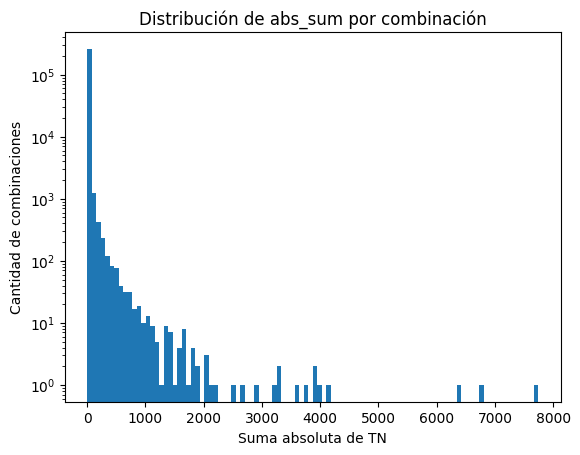

In [8]:
import matplotlib.pyplot as plt

plt.hist(stats['abs_sum'], bins=100, log=True)
plt.title("Distribución de abs_sum por combinación")
plt.xlabel("Suma absoluta de TN")
plt.ylabel("Cantidad de combinaciones")
plt.show()


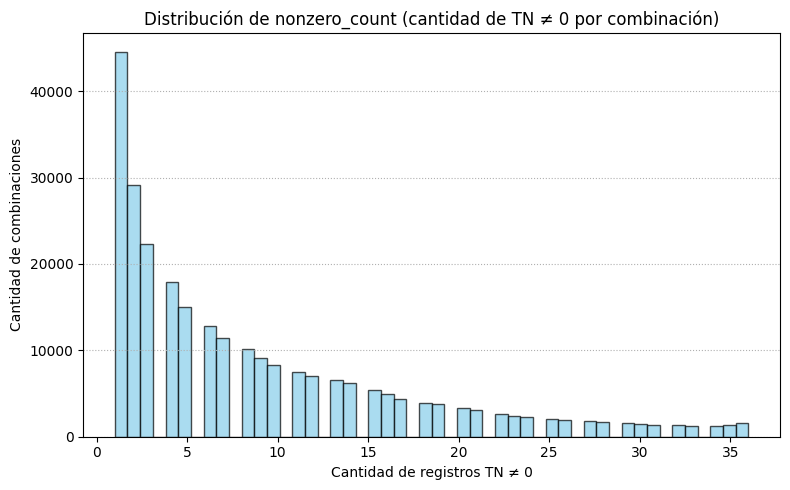

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(stats['nonzero_count'], bins=50, alpha=0.7, color='skyblue', edgecolor='k')
plt.title('Distribución de nonzero_count (cantidad de TN ≠ 0 por combinación)')
plt.xlabel('Cantidad de registros TN ≠ 0')
plt.ylabel('Cantidad de combinaciones')
plt.grid(True, axis='y', linestyle=':')
plt.tight_layout()
plt.show()

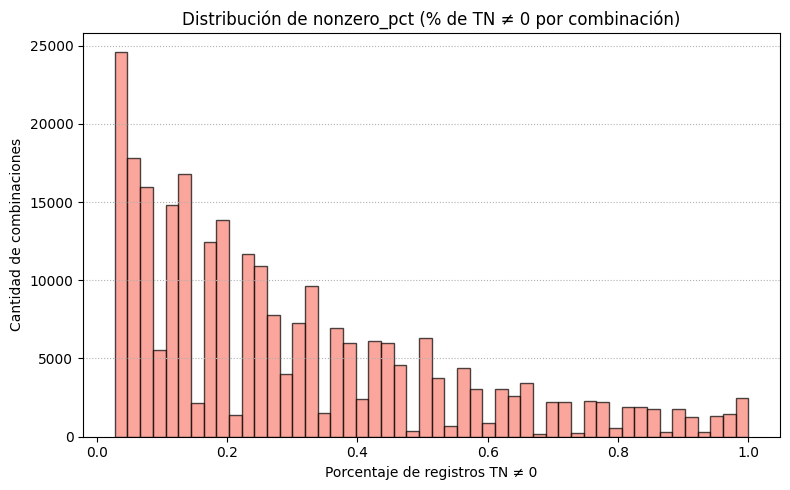

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(stats['nonzero_pct'], bins=50, alpha=0.7, color='salmon', edgecolor='k')
plt.title('Distribución de nonzero_pct (% de TN ≠ 0 por combinación)')
plt.xlabel('Porcentaje de registros TN ≠ 0')
plt.ylabel('Cantidad de combinaciones')
plt.grid(True, axis='y', linestyle=':')
plt.tight_layout()
plt.show()

In [11]:
for min_n in [8, 10, 12, 15]:
    for min_pct in [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
        seleccion = stats[
            (stats['nonzero_count'] >= min_n) &
            (stats['nonzero_pct'] >= min_pct) &
            (stats['abs_sum'] >= min_abs_sum)
        ]
        cobertura = seleccion['abs_sum'].sum() / stats['abs_sum'].sum()
        print(f"min_n_nonzero={min_n}, min_pct_nonzero={min_pct:.2f}: {len(seleccion)} combinaciones, cobertura={cobertura*100:.2f}%")



min_n_nonzero=8, min_pct_nonzero=0.20: 21068 combinaciones, cobertura=88.51%
min_n_nonzero=8, min_pct_nonzero=0.25: 20755 combinaciones, cobertura=88.14%
min_n_nonzero=8, min_pct_nonzero=0.30: 19980 combinaciones, cobertura=87.18%
min_n_nonzero=8, min_pct_nonzero=0.35: 19106 combinaciones, cobertura=85.96%
min_n_nonzero=8, min_pct_nonzero=0.40: 17898 combinaciones, cobertura=84.18%
min_n_nonzero=8, min_pct_nonzero=0.45: 16575 combinaciones, cobertura=82.10%
min_n_nonzero=8, min_pct_nonzero=0.50: 15831 combinaciones, cobertura=80.78%
min_n_nonzero=10, min_pct_nonzero=0.20: 20112 combinaciones, cobertura=87.25%
min_n_nonzero=10, min_pct_nonzero=0.25: 20112 combinaciones, cobertura=87.25%
min_n_nonzero=10, min_pct_nonzero=0.30: 19710 combinaciones, cobertura=86.75%
min_n_nonzero=10, min_pct_nonzero=0.35: 18856 combinaciones, cobertura=85.55%
min_n_nonzero=10, min_pct_nonzero=0.40: 17663 combinaciones, cobertura=83.78%
min_n_nonzero=10, min_pct_nonzero=0.45: 16397 combinaciones, cobertura=

In [12]:
import pandas as pd

# Suponiendo que ya tenés df_full y stats armados

# 1. Definir el filtro para "mueven la aguja"
filtro = (
    (stats['nonzero_count'] >= 10) &
    (stats['nonzero_pct'] >= 0.25) &
    (stats['abs_sum'] >= 5)
)
mueven_aguja = stats[filtro]

# 2. Set de combinaciones activas
set_mueven_aguja = set(zip(mueven_aguja['PRODUCT_ID'], mueven_aguja['CUSTOMER_ID']))

# 3. Filtrar combinaciones que NO mueven la aguja
mask_no_aguja = ~df_full.set_index(['PRODUCT_ID', 'CUSTOMER_ID']).index.isin(set_mueven_aguja)
df_no_aguja = df_full[mask_no_aguja].copy()

# 4. Calcular promedios TN por combinación inactiva
promedios_no_aguja = (
    df_no_aguja
    .groupby(['PRODUCT_ID', 'CUSTOMER_ID'])['TN']
    .mean()
    .reset_index()
    .rename(columns={'TN': 'TN_MEAN'})
)

# 5. Guardar a CSV
promedios_no_aguja.to_csv('promedios_tn_no_mueven_aguja.csv', index=False)

print("Archivo 'promedios_tn_no_mueven_aguja.csv' generado correctamente.")

# 6.  Filtrar df_full para que contenga SOLO los que mueven la aguja
mask_mueven_aguja = df_full.set_index(['PRODUCT_ID', 'CUSTOMER_ID']).index.isin(set_mueven_aguja)
df_full = df_full[mask_mueven_aguja].copy()
print("df_full ahora contiene solo las combinaciones que mueven la aguja:", df_full.shape)

Archivo 'promedios_tn_no_mueven_aguja.csv' generado correctamente.
df_full ahora contiene solo las combinaciones que mueven la aguja: (702853, 95)


In [14]:
# 7. Calcular medianas TN por combinación inactiva
medianas_no_aguja = (
    df_no_aguja
    .groupby(['PRODUCT_ID', 'CUSTOMER_ID'])['TN']
    .median()
    .reset_index()
    .rename(columns={'TN': 'TN_MEDIAN'})
)
medianas_no_aguja.to_csv('medianas_tn_no_mueven_aguja.csv', index=False)

In [13]:
# contar las combinaciones PRODUCT_ID, CUSTOMER_ID que mueven la aguja
print(f"Combinaciones PRODUCT_ID + CUSTOMER_ID que mueven la aguja: {len(set(zip(df_full['PRODUCT_ID'], df_full['CUSTOMER_ID'])))}")


Combinaciones PRODUCT_ID + CUSTOMER_ID que mueven la aguja: 20112


In [94]:
# Agregar una columna que indique la diferencia en ORDINAL entre el ORDINAL actual y el ORDINAL anterior donde TN sea mayor a 0
# para ese CUSTOMER_ID y PRODUCT_ID

from joblib import Parallel, delayed
import numpy as np
import pandas as pd

def calcular_mejoras_por_grupo(grupo):
    grupo = grupo.sort_values('ORDINAL').copy()
    ult_ordinal = None
    valores = []

    for _, row in grupo.iterrows():
        if ult_ordinal is None:
            valores.append(36)
        else:
            valores.append(int(row['ORDINAL'] - ult_ordinal))

        if row['TN'] > 0:
            ult_ordinal = row['ORDINAL']

    grupo['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'] = np.array(valores, dtype=np.int16)
    return grupo

def agregar_diferencia_ordinal_parallel(df: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
    df = df.copy()
    df['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'] = 36  # valor inicial
    df['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'] = df['MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID'].astype('int16')

    # Agrupar por cliente y producto
    grupos = list(df.groupby(['CUSTOMER_ID', 'PRODUCT_ID']))

    # Procesar en paralelo
    resultados = Parallel(n_jobs=n_jobs, backend='loky', batch_size=128)(
        delayed(calcular_mejoras_por_grupo)(grupo) for _, grupo in grupos
    )

    # Concatenar todos los resultados
    df_resultado = pd.concat(resultados, axis=0).sort_index()
    return df_resultado



df_full = agregar_diferencia_ordinal_parallel(df_full, n_jobs=28)

In [95]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd

def calcular_mejoras_por_producto(grupo):
    grupo = grupo.sort_values('ORDINAL').copy()
    ult_ordinal = None
    valores = []

    for _, row in grupo.iterrows():
        if ult_ordinal is None:
            valores.append(36)
        else:
            valores.append(int(row['ORDINAL'] - ult_ordinal))

        if row['TN'] > 0:
            ult_ordinal = row['ORDINAL']

    grupo['MESES_SIN_COMPRAR_PRODUCT_ID'] = np.array(valores, dtype=np.int16)
    return grupo

def agregar_diferencia_ordinal_por_producto(df: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
    df = df.copy()
    df['MESES_SIN_COMPRAR_PRODUCT_ID'] = 36
    df['MESES_SIN_COMPRAR_PRODUCT_ID'] = df['MESES_SIN_COMPRAR_PRODUCT_ID'].astype('int16')

    # Agrupar solo por PRODUCT_ID
    grupos = list(df.groupby('PRODUCT_ID'))

    resultados = Parallel(n_jobs=n_jobs, backend='loky', batch_size=128)(
        delayed(calcular_mejoras_por_producto)(grupo) for _, grupo in grupos
    )

    df_resultado = pd.concat(resultados, axis=0).sort_index()
    return df_resultado

df_full = agregar_diferencia_ordinal_por_producto(df_full, n_jobs=28)


In [96]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd

def calcular_mejoras_por_cliente(grupo):
    grupo = grupo.sort_values('ORDINAL').copy()
    ult_ordinal = None
    valores = []

    for _, row in grupo.iterrows():
        if ult_ordinal is None:
            valores.append(36)
        else:
            valores.append(int(row['ORDINAL'] - ult_ordinal))

        if row['TN'] > 0:
            ult_ordinal = row['ORDINAL']

    grupo['MESES_SIN_COMPRAR_CUSTOMER_ID'] = np.array(valores, dtype=np.int16)
    return grupo

def agregar_diferencia_ordinal_por_cliente(df: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
    df = df.copy()
    df['MESES_SIN_COMPRAR_CUSTOMER_ID'] = 36
    df['MESES_SIN_COMPRAR_CUSTOMER_ID'] = df['MESES_SIN_COMPRAR_CUSTOMER_ID'].astype('int16')

    grupos = list(df.groupby('CUSTOMER_ID'))

    resultados = Parallel(n_jobs=n_jobs, backend='loky', batch_size=128)(
        delayed(calcular_mejoras_por_cliente)(grupo) for _, grupo in grupos
    )

    df_resultado = pd.concat(resultados, axis=0).sort_index()
    return df_resultado

df_full = agregar_diferencia_ordinal_por_cliente(df_full, n_jobs=28)

In [97]:
# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
# Calcular los días del mes usando las columnas ANIO y MES

# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si ANIO==2019 y MES en [6, 8, 10], y 0 en caso contrario
df_full['MES_PROBLEMATICO'] = np.where(
       (df_full['ANIO'] == 2019) & (df_full['MES'].isin([6, 8, 10])),
       1., 0.0
)
df_full['MES_PROBLEMATICO'] = df_full['MES_PROBLEMATICO'].astype(np.float32)

In [98]:
# Guardar el DataFrame en parquet
df_full.to_parquet('./data/interm_NN_TORCH.parquet', index=False, engine='fastparquet')

In [99]:
print(df_full.columns.to_list())

['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 'STOCK_FINAL', 'MEDIA_MOVIL_3M_CLI_PROD', 'MEDIA_MOVIL_6M_CLI_PROD', 'MEDIA_MOVIL_12M_CLI_PROD', 'DESVIO_MOVIL_3M_CLI_PROD', 'DESVIO_MOVIL_6M_CLI_PROD', 'DESVIO_MOVIL_12M_CLI_PROD', 'MEDIA_MOVIL_3M_PROD', 'MEDIA_MOVIL_6M_PROD', 'MEDIA_MOVIL_12M_PROD', 'DESVIO_MOVIL_3M_PROD', 'DESVIO_MOVIL_6M_PROD', 'DESVIO_MOVIL_12M_PROD', 'MEDIA_MOVIL_3M_CLI', 'MEDIA_MOVIL_6M_CLI', 'MEDIA_MOVIL_12M_CLI', 'DESVIO_MOVIL_3M_CLI', 'DESVIO_MOVIL_6M_CLI', 'DESVIO_MOVIL_12M_CLI', 'TN_LAG_01', 'TN_LAG_02', 'TN_LAG_03', 'TN_LAG_04', 'TN_LAG_05', 'TN_LAG_06', 'TN_LAG_07', 'TN_LAG_08', 'TN_LAG_09', 'TN_LAG_10', 'TN_LAG_11', 'TN_LAG_12', 'TN_LAG_13', 'TN_LAG_14', 'TN_LAG_15', 'CLASE', 'CLASE_DELTA', 'ORDINAL', 'TN_DELTA_01', 'TN_DELTA_02', 'TN_DELTA_03', 'TN_DELTA_04', 'TN_DELTA_05', 'TN_DELTA_06', 

In [100]:

# Conservar las siguientes columnas
# #columns_to_keep = ['MES_SIN', 'MES_COS', 'ID_CAT1',
#        'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID',
#        'PRODUCT_ID', 'CUST_REQUEST_QTY',
#        'CUST_REQUEST_TN', 'TN', 'CLASE_DELTA',
#        'ANTIG_CLIENTE','ANTIG_PRODUCTO', 'CANT_PROD_CLI_PER',
#        'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID','MESES_SIN_COMPRAR_PRODUCT_ID','MESES_SIN_COMPRAR_CUSTOMER_ID',
#        'MES_PROBLEMATICO','PERIODO','ORDINAL']
# Filtrar el DataFrame para conservar solo las columnas deseadas 
columns_to_keep = ['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 
                   'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 
                   'MEDIA_MOVIL_3M_CLI_PROD', 'MEDIA_MOVIL_6M_CLI_PROD', 'MEDIA_MOVIL_12M_CLI_PROD', 
                   'DESVIO_MOVIL_3M_CLI_PROD', 'DESVIO_MOVIL_6M_CLI_PROD', 'DESVIO_MOVIL_12M_CLI_PROD', 'MEDIA_MOVIL_3M_PROD', 
                   'MEDIA_MOVIL_6M_PROD', 'MEDIA_MOVIL_12M_PROD', 'DESVIO_MOVIL_3M_PROD', 'DESVIO_MOVIL_6M_PROD', 
                   'DESVIO_MOVIL_12M_PROD', 'MEDIA_MOVIL_3M_CLI', 'MEDIA_MOVIL_6M_CLI', 'MEDIA_MOVIL_12M_CLI', 
                   'DESVIO_MOVIL_3M_CLI', 'DESVIO_MOVIL_6M_CLI', 'DESVIO_MOVIL_12M_CLI', 'TN_LAG_01', 'TN_LAG_02', 'TN_LAG_03', 
                   'TN_LAG_04', 'TN_LAG_05', 'TN_LAG_06', 'TN_LAG_07', 'TN_LAG_08', 'TN_LAG_09', 'TN_LAG_10', 'TN_LAG_11', 
                   'TN_LAG_12', 'TN_LAG_13', 'TN_LAG_14', 'TN_LAG_15','CLASE', 'ORDINAL', 
                   'TN_DELTA_01', 'TN_DELTA_02', 'TN_DELTA_03', 'TN_DELTA_04', 'TN_DELTA_05', 'TN_DELTA_06', 'TN_DELTA_07', 
                   'TN_DELTA_08', 'TN_DELTA_09', 'TN_DELTA_10', 'TN_DELTA_11', 'TN_DELTA_12', 'TN_DELTA_13', 'TN_DELTA_14', 
                   'TN_DELTA_15', 'ANTIG_CLIENTE', 'ANTIG_PRODUCTO', 'CANT_PROD_CLI_PER', 'MEDIA_PROD_PER', 'MEDIA_PROD', 
                   'MEDIA_PER', 'PENDIENTE_TENDENCIA_3', 'TN_EWMA_03', 'TN_MEDIAN_03', 'TN_MIN_03', 'TN_MAX_03', 
                   'PENDIENTE_TENDENCIA_6', 'TN_EWMA_06', 'TN_MEDIAN_06', 'TN_MIN_06', 'TN_MAX_06', 'PENDIENTE_TENDENCIA_9',
                   'TN_EWMA_09', 'TN_MEDIAN_09', 'TN_MIN_09', 'TN_MAX_09', 'PENDIENTE_TENDENCIA_12', 'TN_EWMA_12', 
                   'TN_MEDIAN_12', 'TN_MIN_12', 'TN_MAX_12', 'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID', 
                   'MESES_SIN_COMPRAR_PRODUCT_ID', 'MESES_SIN_COMPRAR_CUSTOMER_ID', 'MES_PROBLEMATICO']
df_full = df_full[columns_to_keep]

In [101]:
import numpy as np

def log_transform_signed(x):
    """
    Transformación log1p con signo.
    Para variables continuas con valores negativos, cero y positivos.
    """
    return np.sign(x) * np.log1p(np.abs(x))

def inverse_log_transform_signed(x):
    """
    Inversa de la transformación log1p con signo.
    Devuelve valores en la escala original.
    """
    return np.sign(x) * np.expm1(np.abs(x))

# Aplicar transformación
df_full['CLASE_LOG1P'] = log_transform_signed(df_full['CLASE'])

# Ejemplo de uso de la inversa:
# toneladas_originales = inverse_log_transform_signed(df_full['CLASE_LOG1P'])


In [102]:
from sklearn.preprocessing import StandardScaler

# FIT scaler solo sobre entrenamiento
mask_train = df_full['PERIODO'] <= 201908
scaler_y = StandardScaler()
scaler_y.fit(df_full.loc[mask_train, ['CLASE_LOG1P']])

# Aplicar la transformación a todo df_full
df_full['CLASE_LOG1P_Z'] = scaler_y.transform(df_full[['CLASE_LOG1P']])

# Guardar media y std
media_y = scaler_y.mean_[0]
std_y = scaler_y.scale_[0]
print(f"Media usada (entrenamiento): {media_y}")
print(f"Std usada (entrenamiento): {std_y}")


Media usada (entrenamiento): 0.4756487705286022
Std usada (entrenamiento): 0.6596333033693771


In [103]:
# Eliminar las columnas CLASE y CLASE_LOG1P para evitar confusiones
df_full.drop(columns=['CLASE', 'CLASE_LOG1P'], inplace=True, errors='ignore')

In [104]:


cat_cols = ['ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE','ANIO', 'MES','TRIMESTRE','MES_PROBLEMATICO']

for col in cat_cols:
    if df_full[col].isnull().any():
        df_full[col] = df_full[col].fillna("missing")


encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_full.loc[:, col] = le.fit_transform(df_full[col]).astype(int)
    encoders[col] = le  # para guardar los mapeos por si necesitás revertirlos


In [105]:
# Guardo los encoders en archivos .pkl
import joblib
import os

os.makedirs('encoders', exist_ok=True)

for col, le in encoders.items():
    joblib.dump(le, f'encoders/{col}_encoder.pkl')

In [106]:
# Guardar el DataFrame en parquet
df_full.to_parquet('./data/interm_NN_TORCH.parquet', index=False, engine='fastparquet')

In [107]:
df_full = pd.read_parquet('./data/interm_NN_TORCH.parquet', index=False, engine='fastparquet')

In [108]:
# Excluir la variable de clase
cols_to_check = df_full.columns.difference(['CLASE_LOG1P_Z'])

# Calcular cantidad de NaNs por columna
nan_columns = df_full[cols_to_check].isna().sum()

# Filtrar solo las columnas que tienen al menos un NaN
nan_columns = nan_columns[nan_columns > 0].sort_values(ascending=False)

# Mostrar
print(nan_columns)

PENDIENTE_TENDENCIA_12    221212
TN_EWMA_12                221212
TN_MEDIAN_12              221212
TN_MAX_12                 221212
TN_MIN_12                 221212
TN_EWMA_09                160896
PENDIENTE_TENDENCIA_9     160896
TN_MEDIAN_09              160896
TN_MIN_09                 160896
TN_MAX_09                 160896
TN_EWMA_06                100560
TN_MAX_06                 100560
TN_MEDIAN_06              100560
PENDIENTE_TENDENCIA_6     100560
TN_MIN_06                 100560
TN_EWMA_03                 40224
TN_MAX_03                  40224
PENDIENTE_TENDENCIA_3      40224
TN_MEDIAN_03               40224
TN_MIN_03                  40224
dtype: int64


In [109]:
# Para las columnas con NaN, si son PENDIENTE_TENDENCIA_nn reemplazar por 0,
# sin son TN_EWMA reemplazar por la media de la columna
for col in nan_columns.index:
    if 'PENDIENTE_TENDENCIA' in col:
        df_full[col].fillna(0, inplace=True)
    elif 'TN_EWMA' in col:
        media_col = df_full[col].mean()
        df_full[col].fillna(media_col, inplace=True)
    elif 'TN_MIN' in col or 'TN_MAX' in col or 'TN_MEDIAN' in col:
        media_col = df_full[col].mean()
        df_full[col].fillna(media_col, inplace=True)
    

/tmp/ipykernel_12955/2542019331.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_full[col].fillna(0, inplace=True)
/tmp/ipykernel_12955/2542019331.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [110]:
# Excluir la variable de clase
cols_to_check = df_full.columns.difference(['CLASE_LOG1P_Z'])

# Calcular cantidad de NaNs por columna
nan_columns = df_full[cols_to_check].isna().sum()

# Filtrar solo las columnas que tienen al menos un NaN
nan_columns = nan_columns[nan_columns > 0].sort_values(ascending=False)

# Mostrar
print(nan_columns)

Series([], dtype: int64)


In [111]:
print(f"📊 DataFrame final con {df_full.shape[0]:,} filas y {df_full.shape[1]} columnas:")

📊 DataFrame final con 702,853 filas y 96 columnas:


In [112]:
# Copia de seguridad
df = df_full.copy()


# === Binning (en deciles) ===
df['CUSTOMER_RANK_BIN'] = pd.qcut(df['CUSTOMER_ID'], q=10, labels=False)
df['CUSTOMER_RANK_BIN'] = df['CUSTOMER_RANK_BIN'].astype('category')

# Validación opcional
assert df['CUSTOMER_RANK_BIN'].isna().sum() == 0, "NaNs en qcut"

# Reemplazar en df_full
df_full = df



In [113]:
# Copia de seguridad del DataFrame
df = df_full.copy()

# === Binning (en deciles) ===
df['PRODUCT_RANK_BIN'] = pd.qcut(df['PRODUCT_ID'], q=10, labels=False)
df['PRODUCT_RANK_BIN'] = df['PRODUCT_RANK_BIN'].astype('category')

# Reemplazar en el DataFrame principal
df_full = df


In [114]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Copia del DataFrame original
df = df_full.copy()

# 1. Columnas categóricas (auto si no existen)
if 'cat_cols' not in locals():
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in ['CUSTOMER_RANK_BIN', 'PRODUCT_RANK_BIN']:
    if col not in cat_cols:
        cat_cols.append(col)

# 2. Columnas a excluir del escalado
excluir = ['PERIODO', 'CLASE_LOG1P_Z', 'MES_SIN', 'MES_COS'] + cat_cols
print("Columnas excluidas del escalado:", excluir)

# 3. Columnas numéricas a escalar
cols_a_escalar = [
    col for col in df.columns
    if col not in excluir and pd.api.types.is_numeric_dtype(df[col])
]
print("Columnas numéricas a escalar:", cols_a_escalar)

# 4. Entrenamiento del scaler SOLO con datos de entrenamiento
df_entrenamiento = df[df['PERIODO'] <= 201910].copy()
scaler = StandardScaler()
scaler.fit(df_entrenamiento[cols_a_escalar])

# 5. Aplicación del scaler a TODO el dataset
valores_escalados = scaler.transform(df[cols_a_escalar])
df_scaled = pd.DataFrame(
    valores_escalados,
    columns=[col + '_Z' for col in cols_a_escalar],
    index=df.index
)

# 6. Eliminar columnas originales escaladas (excepto IDs)
cols_a_borrar = [col for col in cols_a_escalar if col not in ['CUSTOMER_ID', 'PRODUCT_ID']]
df.drop(columns=cols_a_borrar, inplace=True)

# 7. Concatenar columnas escaladas
df = pd.concat([df, df_scaled], axis=1)

# 8. Guardar el scaler
os.makedirs('./encoders', exist_ok=True)
joblib.dump(scaler, './encoders/scaler_features_numericas.pkl')
print("Scaler guardado en './encoders/scaler_features_numericas.pkl'")

# 9. Actualizar df_full
df_full = df

print("Shape final del DataFrame:", df_full.shape)
print("Primeras columnas escaladas:\n", df_full[[col + '_Z' for col in cols_a_escalar]].head())



Columnas excluidas del escalado: ['PERIODO', 'CLASE_LOG1P_Z', 'MES_SIN', 'MES_COS', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'ANIO', 'MES', 'TRIMESTRE', 'MES_PROBLEMATICO', 'CUSTOMER_RANK_BIN', 'PRODUCT_RANK_BIN']
Columnas numéricas a escalar: ['CUSTOMER_ID', 'PRODUCT_ID', 'CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 'MEDIA_MOVIL_3M_CLI_PROD', 'MEDIA_MOVIL_6M_CLI_PROD', 'MEDIA_MOVIL_12M_CLI_PROD', 'DESVIO_MOVIL_3M_CLI_PROD', 'DESVIO_MOVIL_6M_CLI_PROD', 'DESVIO_MOVIL_12M_CLI_PROD', 'MEDIA_MOVIL_3M_PROD', 'MEDIA_MOVIL_6M_PROD', 'MEDIA_MOVIL_12M_PROD', 'DESVIO_MOVIL_3M_PROD', 'DESVIO_MOVIL_6M_PROD', 'DESVIO_MOVIL_12M_PROD', 'MEDIA_MOVIL_3M_CLI', 'MEDIA_MOVIL_6M_CLI', 'MEDIA_MOVIL_12M_CLI', 'DESVIO_MOVIL_3M_CLI', 'DESVIO_MOVIL_6M_CLI', 'DESVIO_MOVIL_12M_CLI', 'TN_LAG_01', 'TN_LAG_02', 'TN_LAG_03', 'TN_LAG_04', 'TN_LAG_05', 'TN_LAG_06', 'TN_LAG_07', 'TN_LAG_08', 'TN_LAG_09', 'TN_LAG_10', 'TN_LAG_11', 'TN_LAG_12', 'TN_LAG_13', 'TN_LAG_14', 'TN_LAG_15', 'ORDINAL', 'TN_DELTA_01

In [115]:
print(df_full.columns.tolist())

['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'MES_PROBLEMATICO', 'CLASE_LOG1P_Z', 'CUSTOMER_RANK_BIN', 'PRODUCT_RANK_BIN', 'CUSTOMER_ID_Z', 'PRODUCT_ID_Z', 'CUST_REQUEST_QTY_Z', 'CUST_REQUEST_TN_Z', 'TN_Z', 'MEDIA_MOVIL_3M_CLI_PROD_Z', 'MEDIA_MOVIL_6M_CLI_PROD_Z', 'MEDIA_MOVIL_12M_CLI_PROD_Z', 'DESVIO_MOVIL_3M_CLI_PROD_Z', 'DESVIO_MOVIL_6M_CLI_PROD_Z', 'DESVIO_MOVIL_12M_CLI_PROD_Z', 'MEDIA_MOVIL_3M_PROD_Z', 'MEDIA_MOVIL_6M_PROD_Z', 'MEDIA_MOVIL_12M_PROD_Z', 'DESVIO_MOVIL_3M_PROD_Z', 'DESVIO_MOVIL_6M_PROD_Z', 'DESVIO_MOVIL_12M_PROD_Z', 'MEDIA_MOVIL_3M_CLI_Z', 'MEDIA_MOVIL_6M_CLI_Z', 'MEDIA_MOVIL_12M_CLI_Z', 'DESVIO_MOVIL_3M_CLI_Z', 'DESVIO_MOVIL_6M_CLI_Z', 'DESVIO_MOVIL_12M_CLI_Z', 'TN_LAG_01_Z', 'TN_LAG_02_Z', 'TN_LAG_03_Z', 'TN_LAG_04_Z', 'TN_LAG_05_Z', 'TN_LAG_06_Z', 'TN_LAG_07_Z', 'TN_LAG_08_Z', 'TN_LAG_09_Z', 'TN_LAG_10_Z', 'TN_LAG_11_Z', 'TN_LAG_12_Z', 'TN_LAG_13_Z', 'TN_LAG_14_Z

In [116]:
# Excluir la variable de clase
cols_to_check = df_full.columns.difference(['CLASE_LOG1P_Z'])

# Calcular cantidad de NaNs por columna
nan_columns = df_full[cols_to_check].isna().sum()

# Filtrar solo las columnas que tienen al menos un NaN
nan_columns = nan_columns[nan_columns > 0].sort_values(ascending=False)

# Mostrar
print(nan_columns)

Series([], dtype: int64)


In [117]:
print(df_full.shape)
# Guardar el DataFrame resultante en un archivo parquet
df_full.to_parquet('./data/train_val_NN_TORCH.parquet', engine='fastparquet', index=False)

(702853, 100)


In [118]:
print(cat_cols)

['ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'ANIO', 'MES', 'TRIMESTRE', 'MES_PROBLEMATICO', 'CUSTOMER_RANK_BIN', 'PRODUCT_RANK_BIN']
